In [14]:
# Import necessary libraries
from fastai.basics import *
from fastai.data.all import *
from fastai.vision.all import *
from fastai.callback.all import *

from fastai.metrics import *
from fastai.callback.wandb import *

import numpy as np
from PIL import Image

from matplotlib import pyplot as plt

from tqdm.notebook import tqdm
import pandas as pd

tqdm.pandas()
import os
import cv2
import shutil

import matplotlib.image as mpimg
from matplotlib import rcParams

from random import sample

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 16 ,8
import os

In [2]:
root_path = Path("/scratch/rc4499/CheXpert-v1.0-small")
root_path.ls()

(#4) [Path('/scratch/rc4499/CheXpert-v1.0-small/valid.csv'),Path('/scratch/rc4499/CheXpert-v1.0-small/valid'),Path('/scratch/rc4499/CheXpert-v1.0-small/train.csv'),Path('/scratch/rc4499/CheXpert-v1.0-small/train')]

In [3]:
train_df = pd.read_csv(root_path/"train.csv")
val_df = pd.read_csv(root_path/"valid.csv")

train_df = train_df[train_df["Frontal/Lateral"] == "Frontal"]
val_df = val_df[val_df["Frontal/Lateral"] == "Frontal"]
train_df

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/view1_frontal.jpg,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/view1_frontal.jpg,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN
2,CheXpert-v1.0-small/train/patient00002/study1/view1_frontal.jpg,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,CheXpert-v1.0-small/train/patient00003/study1/view1_frontal.jpg,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
5,CheXpert-v1.0-small/train/patient00004/study1/view1_frontal.jpg,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223409,CheXpert-v1.0-small/train/patient64537/study2/view1_frontal.jpg,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,-1.0,0.0,1.0,NaN,NaN,NaN
223410,CheXpert-v1.0-small/train/patient64537/study1/view1_frontal.jpg,Male,59,Frontal,AP,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,0.0,-1.0,NaN,-1.0,NaN,NaN,NaN
223411,CheXpert-v1.0-small/train/patient64538/study1/view1_frontal.jpg,Female,0,Frontal,AP,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
223412,CheXpert-v1.0-small/train/patient64539/study1/view1_frontal.jpg,Female,0,Frontal,AP,NaN,NaN,1.0,1.0,NaN,NaN,NaN,-1.0,1.0,0.0,NaN,NaN,NaN,0.0


In [4]:
def get_label(row):
    if row["Pneumonia"] == 1.0:
        return "PNEUMONIA"
    elif row["No Finding"] == 1.0 and row["Support Devices"] != 1.0:
        return "NORMAL"
    else:
        return np.nan

train_df["label"] = train_df.apply(get_label, axis=1)
train_df_new = train_df[~train_df["label"].isnull()]

val_df["label"] = val_df.apply(get_label, axis=1)
val_df_new = val_df[~val_df["label"].isnull()]

In [5]:
train_df[train_df["label"] == "PNEUMONIA"].describe()

,Age,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
count,4675.000000,0.0,627.000000,628.000000,3474.000000,384.000000,1713.000000,1558.000000,4675.0,1143.000000,606.000000,1957.000000,144.000000,131.000000,1672.000000
mean,62.461176,NaN,-0.151515,0.431529,0.877087,0.703125,0.387040,0.226573,1.0,-0.115486,0.165017,0.604497,0.277778,0.801527,0.939593
std,18.587588,NaN,0.724520,0.790752,0.453580,0.662609,0.855982,0.856806,0.0,0.988886,0.473249,0.676013,0.904104,0.471003,0.266748
min,18.000000,NaN,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,50.000000,NaN,-1.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.0,-1.000000,0.000000,0.000000,-1.000000,1.000000,1.000000
50%,64.000000,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,77.000000,NaN,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
max,90.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
train_df_new["label"].value_counts()

NORMAL       9553
PNEUMONIA    4675
Name: label, dtype: int64

<AxesSubplot:>

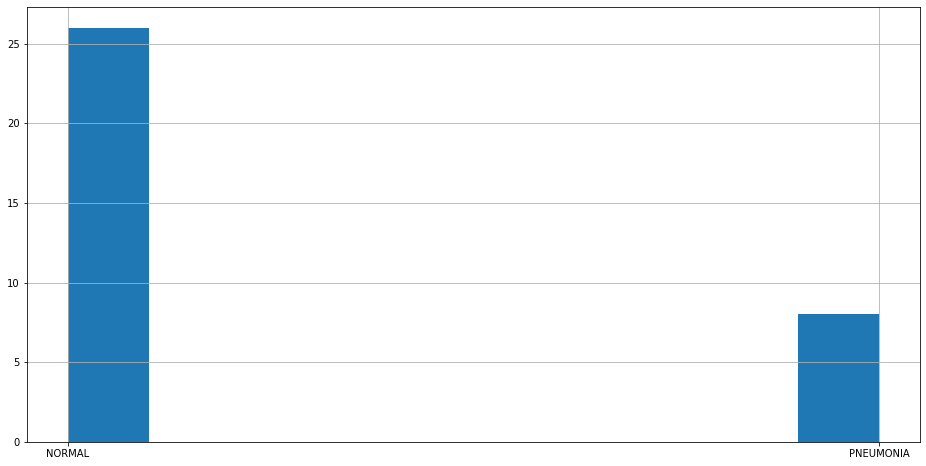

In [6]:
val_df_new["label"].hist()

# Copy Dataset into Folder Organised Version

In [11]:
# First create the output folders
output_path = Path("/scratch/rc4499/chexpert_pn/imgs")
orig_base_path = Path("/scratch/rc4499/")
for c in train_df_new.label.unique():
    os.makedirs(output_path/c, exist_ok=True)

In [15]:
def copy_img(row):
    orig_path = orig_base_path/row["Path"]
    # patient00001/study1/view1_frontal.jpg
    new_fname = "_".join(row["Path"].split("/")[2:])
    new_path = output_path/row["label"]/new_fname
    
    # print(f"Copying file from {orig_path} to {new_path}")
    shutil.copyfile(orig_path, new_path)
                         
train_df_new.progress_apply(copy_img, axis=1)

  0%|          | 0/14228 [00:00<?, ?it/s]

5         None
11        None
18        None
40        None
58        None
          ... 
223384    None
223385    None
223389    None
223391    None
223413    None
Length: 14228, dtype: object

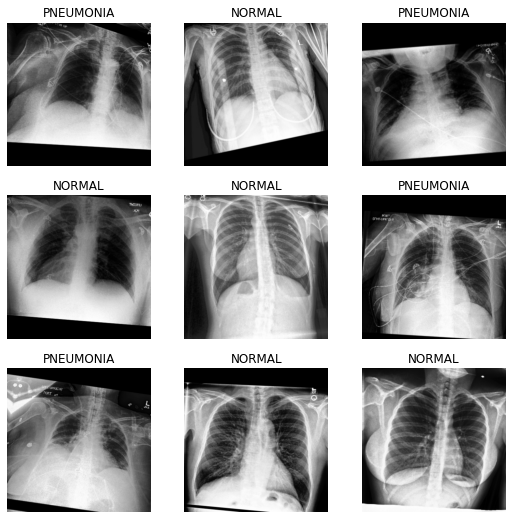

In [12]:
dls = ImageDataLoaders.from_df(train_df_new, path="/scratch/rc4499/", seed=42,
                               fn_col="Path", label_col="label", bs=32,
                              batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                            item_tfms=Resize(448, method="pad", pad_mode="zeros"))

dls.show_batch()

In [15]:
learn = cnn_learner(dls, models.resnet50, metrics = [accuracy, F1Score(), RocAucBinary()])
learn.load('/home/rc4499/models/pneumonia-convexhull-model')

In [18]:
learn.fit_one_cycle(5, lr_max=3e-4)

epoch,train_loss,valid_loss,accuracy,f1_score,roc_auc_score,time
0,0.865701,0.616125,0.747276,0.642822,0.799833,02:21
1,0.658637,0.510538,0.793322,0.678689,0.838602,02:18
2,0.572110,0.444913,0.803515,0.677810,0.861460,02:18
3,0.497248,0.415494,0.819684,0.686622,0.873794,02:18
4,0.477628,0.418446,0.824253,0.686717,0.875377,02:18


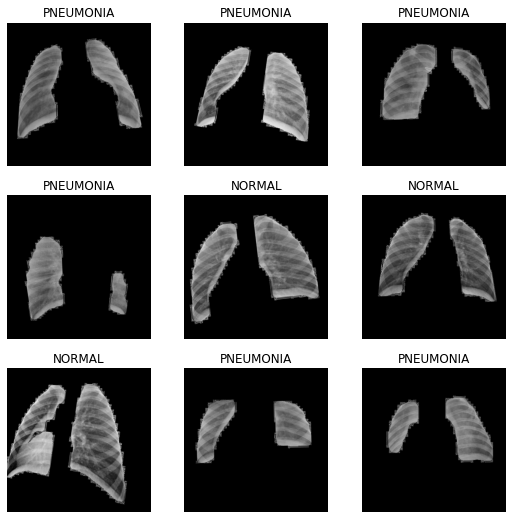

In [72]:
new_dls = ImageDataLoaders.from_folder("/scratch/rc4499/masked/pneumonia/raw", 
                                       valid_pct=0.01,
                                        bs=32, num_workers=2, 
        batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
        item_tfms=None)
new_dls.show_batch()

In [16]:
print("valid_loss	accuracy	f1_score	roc_auc_score")
# learn.validate(dl=new_dls.train)
learn.validate()

valid_loss	accuracy	f1_score	roc_auc_score


(#4) [3.382659673690796,0.39015817642211914,0.511680270194202,0.6959750567531461]

In [17]:
learn = cnn_learner(dls, models.resnet50, metrics = [accuracy, F1Score(), RocAucBinary()])
learn.load('/home/rc4499/models/pneumonia-none-model')
learn.validate()

(#4) [0.9692108035087585,0.685764491558075,0.4838337182448037,0.7175184609514721]

In [58]:
# dl = learn.dls.test_dl(fnames[:5])
preds = learn.get_preds()
preds

(TensorBase([[0.9895, 0.0105],
         [0.9976, 0.0024],
         [0.7070, 0.2930],
         ...,
         [0.8621, 0.1379],
         [0.9638, 0.0362],
         [0.7867, 0.2133]]),
 TensorCategory([0, 0, 1,  ..., 0, 0, 1]))